# Analysis of the 1D wave equation solver

In this notebook we will gather and compute statistics about the quantum circuit solving the 1D wave equation.

## 1. Warm up

First, we start by importing all the modules we will need. 

The `qaths` module needs a special treatment as it is not installed in the Python distribution but rather just copy-pasted to a directory.

We also activate $\LaTeX$ rendering in matplotlib.

In [1]:
try:
    import qaths
except ImportError:
    # If we can't find qaths, then try to add some directory where it could be.
    # First, we determine the current notebook directory.
    import os
    if not 'workbookDir' in globals():
        workbookDir = os.getcwd()
    
    def is_root(path: str) -> bool:
        path = os.path.realpath(path)
        return path == os.path.dirname(path)
    
    # Then we try to find qaths in a parent directory.
    import sys
    current_dir = os.path.dirname(os.path.abspath(workbookDir))
    import_successfull = False
    # Loop in parent directories until we can import qaths or we 
    # find the root.
    while not (import_successfull or is_root(current_dir)):
        sys.path.append(current_dir)
        try:
            import qaths
        except ImportError:
            # Remove the added directory from the PYTHONPATH in order to
            # not pollute it with a lot of useless directories.
            sys.path.pop()
            current_dir = os.path.dirname(current_dir)
        else:
            print("Found qaths library in {}.".format(current_dir))
            import_successfull = True
    
    # If qaths has not been successfully imported, warn the user.
    if not import_successfull:
        print("qaths not found!")

Found qaths library in /home/adrisuau/qlm_notebook/notebook/qaths.


In [2]:
# File-related operations
import os
# Parallelisation of computations
import concurrent.futures
import multiprocessing
# Regex searching / replacing
import re
# Python scientific libraries
import numpy
import pandas
import scipy.optimize as sopt
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.ticker
# time module to time function execution
import time as timemodule
import pickle

from IPython.display import display, Math, Latex

# Wave equation quantum solver
from qaths.applications.wave_equation.utils import compute_qubit_number_from_considered_points_1D
from qaths.applications.wave_equation.evolve_1D_dirichlet import solve_1D_dirichlet_stationary
# qaths translators
from qaths.hardware_models.IBMQ import circ_to_ibmq_basis
# qat specific 
from qat.lang.AQASM import Program
from qat.graphopt import Graphopt
from qat.core.simutil import optimize_circuit
from qat.noisy.util import start_and_end_times

In [3]:
# Activate LaTeX rendering in plots
#from matplotlib import rc, rcParams
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
#rc('text', usetex=True)

matplotlib_dpi = 200

## 2. Statistics computation

All the needed modules have been successfully imported, we can now compute/recover the data we want to analyse.

Computations of data of interest are all performed in the `get_statistics` function. This function returns a dictionnary with the following caracteristics:
* The dictionnary contains an integer entry for the key `"discretisation_points_number"`. This integer is the number of discretisation points used to compute the statistics
* All the other keys are strings describing the **integer** value associated with it.

In [4]:
## A small "hack" of a function that creates a space time diagram of the quantum circuit using a map of gate times
def get_melbourne_depth(circuit):
    """
    Returns the depth of a circuit given some gate passing times.
    """
    gate_times = {"U1" : 0, "U2" : 100 + 20, "U3" : 100 + 20 + 100 + 20, "CX": 100 + 20 + 347 + 20 + 100 + 20 + 347 + 20}

    _, start_times, end_times = start_and_end_times(circuit, gate_times)
    return max(max(e for e in end_times))

In [5]:
def get_statistics(discretisation_points_number: int) -> numpy.ndarray:

    # The value here is not important as the data gathered (gate number, 
    # generation time and arity) does not depend on this value.
    random_time = 1.07939369
    
    res = {"discretisation_points_number" : discretisation_points_number}
    
    ###################################
    # 1. Generate the quantum circuit #
    ###################################
    # 1. Compute the number of qubits we will need
    n = compute_qubit_number_from_considered_points_1D(discretisation_points_number-2)

    # 2. Create the QRoutine solving the wave equation and time it.
    start_gen = timemodule.time()
    solve_gate = solve_1D_dirichlet_stationary(random_time, 
                                               discretisation_points_number, 
                                               None, 
                                               1)
    end_gen = timemodule.time()
    
    # 3. Initialise the quantum program and allocate the needed qubits.
    prog = Program()
    x = prog.qalloc(n)
    m = prog.qalloc(n)
    w = prog.qalloc(1)
    p = prog.qalloc(1)
    s = prog.qalloc(1)
    p2 = prog.qalloc(1)
    ancilla = prog.qalloc(solve_gate.arity - (2*n+4))

    # 4. Apply the QRoutine and time it.
    start_apply = timemodule.time()
    prog.apply(solve_gate, 
               x, m, w, p, s, p2, ancilla)
    end_apply = timemodule.time()

    # 5. Translate the quantum program to a Circuit and time it.
    start_circ = timemodule.time()
    circ = prog.to_circ()    
    end_circ = timemodule.time()
    ###################################
    # 2.        Optimisations         #
    ###################################
    # 1. Expand the gates with Graphopt and keep the expended circuit.
    start_expand_graphopt = timemodule.time()
    circ_exp = optimize_circuit(circ, Graphopt(expandonly=True))
    end_expand_graphopt = timemodule.time()
    
    # 2. Optimise the circuit with Graphopt and keep the optimised circuit.
    start_opti_graphopt = timemodule.time()
    circ_opt = optimize_circuit(circ_exp, Graphopt())
    end_opti_graphopt = timemodule.time()

    # 3. Expand the original circuit to the IBMQ basis.
    start_ibmq_exp = timemodule.time()
    ibmq_circ = circ_to_ibmq_basis(circ)
    end_ibmq_exp = timemodule.time()
    
    # 4. Apply some optimisations on the IBMQ circuit.
    # No optimisation implemented for the moment...
    start_ibmq_opt = timemodule.time()
    ibmq_circ_opt = ibmq_circ
    end_ibmq_opt = timemodule.time()
    
    #####################################
    # 3. Extraction of other statistics #
    #####################################
    # 0. Definition of useful functions
    def get_gate_name(gate, gateDic) -> str:
        """Return the name of the given gate."""
        if gate.syntax is not None:
            return gate.syntax.name
        elif gate.is_ctrl:
            return "CTRL({})".format(get_gate_name(gateDic[gate.subgate], gateDic))
        else:
            raise RuntimeError("Unsupported operation in get_gate_name: {}".format(gate))

    def compute_gate_count(circuit):
        """Return a dictionnary with gate names as key and the corresponding gate count."""
        # 1. Recover the gate names
        gate_names = dict()
        for gate_id in circuit.gateDic:
            gate_names[gate_id] = get_gate_name(circuit.gateDic[gate_id], circuit.gateDic)
        # 2. Compute the gate count
        gate_count = dict()
        for op in circuit.ops:
            gate_count[gate_names[op.gate]] = gate_count.get(gate_names[op.gate], 0) + 1
        return gate_count

    # 1. Compute the gate count
    circ_gate_count = compute_gate_count(circ)
    circ_exp_gate_count = compute_gate_count(circ_exp)
    circ_opt_gate_count = compute_gate_count(circ_opt)
    ibmq_circ_gate_count = compute_gate_count(ibmq_circ)
    ibmq_circ_opt_gate_count = compute_gate_count(ibmq_circ_opt)
   
    # 2. Compute the running time on the real quantum hardware Melbourne.
    melbourne_exec_time_ns = get_melbourne_depth(ibmq_circ)

    ###################################
    # 4.     Statistics gathering     #
    ###################################
    # Arity
    res["arity"] = solve_gate.arity
    # Melbourne execution time
    res["Melbourne_execution_time_ns"] = melbourne_exec_time_ns
    # Timings
    res["Generation_time_ms"] = (end_gen - start_gen) * 10**3
    res["Application_time_ms"] = (end_apply - start_apply) * 10**3
    res["To_circuit_time_ms"] = (end_circ - start_circ) * 10**3
    res["Graphopt_expand_time_ms"] = (end_expand_graphopt - start_expand_graphopt) * 10**3
    res["Graphopt_optimise_time_ms"] = (end_opti_graphopt - start_opti_graphopt) * 10**3
    res["IBMQ_expand_time_ms"] = (end_ibmq_exp - start_ibmq_exp) * 10**3
    res["IBMQ_optimise_time_ms"] = (end_ibmq_opt - start_ibmq_opt) * 10**3
    # Gate count
    res["circ_gate_count"] = circ_gate_count
    res["circ_exp_gate_count"] = circ_exp_gate_count
    res["circ_opt_gate_count"] = circ_opt_gate_count
    res["ibmq_circ_gate_count"] = ibmq_circ_gate_count
    res["ibmq_circ_opt_gate_count"] = ibmq_circ_opt_gate_count
        
    return res

In [6]:
# Variables used to determine the discretisation values that will be tested.
# The discretisation values are evenly spaced on a log scale.
base = 2
low, up = 4, 50
number_of_samples = 100
discretisation_values = numpy.logspace(low, up, number_of_samples, base=base).astype(numpy.int)

# File where we want to save the data in order to avoid recomputing everything
PICKLE_SAVE_FILE = "{}_{}_{}_{}.pkl".format(base, low, up, number_of_samples)

if os.path.isfile(PICKLE_SAVE_FILE):
    with open(PICKLE_SAVE_FILE, 'rb') as f:
        arities, time_statistics, gate_statistics, melbourne_exec_time = pickle.load(f)
else:
    arities = dict()
    time_statistics = dict()
    melbourne_exec_time = dict()
    gate_statistics = dict()
    
    print("Computing statistics. The first iteration might be several minutes long "
          "(depending on the highest value of discretisation_values).")
    print("Computed statistic {}/{}.".format(0, number_of_samples), end='\t\r', flush=True)
    with concurrent.futures.ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()//2 - 2) as executor:
        # We execute with the discretisation values in reverse in order to optimise the time took by the
        # loop. The longer call is no longer done at the end but rather at the beginning.
        for idx, result in enumerate(executor.map(get_statistics, discretisation_values[::-1])):
            print("Computed statistic {}/{}.".format(idx+1, number_of_samples), end='\t\r', flush=True)
            discretisation_point_number = result.pop("discretisation_points_number")
            time_statistics[discretisation_point_number] = dict()
            for key, val in result.items():
                if key == "arity":
                    arities[discretisation_point_number] = val
                elif key == "Melbourne_execution_time_ns":
                    melbourne_exec_time[discretisation_point_number] = val
                elif key.endswith("gate_count"):
                    gate_statistics.setdefault(key, dict())[discretisation_point_number] = val
                elif key.endswith("time_ms"):
                    time_statistics[discretisation_point_number][key] = val
                else:
                    print("Un-handled key: '{}'.".format(key))

    # Create pandas data structures
    arities = pandas.Series(arities)
    melbourne_exec_time = pandas.Series(melbourne_exec_time)
    time_statistics = pandas.DataFrame.from_dict(time_statistics)
    gate_statistics = pandas.concat({key: pandas.DataFrame.from_dict(stats) for key, stats in gate_statistics.items()})
    # Export to pickle
    with open(PICKLE_SAVE_FILE, 'wb') as f:
        pickle.dump([arities, time_statistics, gate_statistics, melbourne_exec_time], f)

## 3. Plotting and fitting data -- Prepare step

It is now time to plot the data collected and to try to fit this data to some mathematical function in order to have an idea of the asymptotic behaviour.

### 1. Data fitting

Several of the quantities of interest that we will plot theoretically have an asymptotical complexity in polylog. The following cell define some functions that will be used to try to fit the data to a polylog function.

In [7]:
def get_polylog_func(n: int):
    def polylog_func(x, *args):
        ret = args[0]
        for power in range(n):
            ret = ret + args[1+3*power] * numpy.power(numpy.log(numpy.abs(args[2+3*power] + args[3+3*power]*x)), power+1)
        return ret
    return polylog_func

def get_polylog_jac(n: int):
    def polylog_jac(x, *args):
        ret = numpy.zeros((x.size, 3*n+1), dtype=numpy.float)
        ret[:, 0] = numpy.ones((x.size,))
        for power in range(n):
            ret[:, 1+3*power] = numpy.power(numpy.log(numpy.abs(args[2+3*power] + args[3+3*power]*x)), power+1)
            ret[:, 2+3*power] = (power+1) * args[1+3*power] / (args[2+3*power] + args[3+3*power] * x) * numpy.power(numpy.log(numpy.abs(args[2+3*power] + args[3+3*power]*x)), power)
            ret[:, 3+3*power] = (power+1) * args[1+3*power] * x / (args[2+3*power] + args[3+3*power] * x) * numpy.power(numpy.log(numpy.abs(args[2+3*power] + args[3+3*power]*x)), power)
        return ret
    return polylog_jac

def get_polylog_latex(n: int, *args: float) -> str:
    assert len(args) == 3*n+1, "The number of coefficients ({}) does not match the given n ({}).".format(len(args), n)
    
    math_latex = ""
    if not numpy.isclose(args[0], 0, atol=1e-2):
        math_latex += r"{0:.2f}".format(args[0])
    for power in range(1, n+1):
        if not numpy.isclose(args[1+3*(power-1)], 0, atol=1e-2):
            math_latex += r"{0:+.2f}\log_2".format(args[1+3*(power-1)])
            if power > 1:
                math_latex += r"^{" + str(power) + "}"
            math_latex += r"\left( \left\vert"
            if not numpy.isclose(args[2+3*(power-1)], 0, atol=1e-2):
                math_latex += r"{0:.2f}".format(args[2+3*(power-1)])
            if not numpy.isclose(args[3+3*(power-1)], 0, atol=1e-2):
                math_latex += r"{0:+.2f} x".format(args[3+3*(power-1)])
            math_latex += r"\right\vert\right)"
    return "${}$".format(math_latex)
        
def fit_to_polylog(X, Y, n):
    exception = None
    for method in ['lm', 'trf', 'dogbox']:
        try:
            print("Trying {}... ".format(method), end="")
            popt, pcov = sopt.curve_fit(get_polylog_func(n), 
                                        X, Y, p0 = [1] + [1, 1, 1]*n, 
                                        method=method, 
                                        jac=get_polylog_jac(n)
                                        )
        except RuntimeError as e:
            print("Failed!")
            exception = e
        else:
            print("Succeed!")
            return popt
    raise exception

fit_to_log = lambda X, Y : fit_to_polylog(X, Y, 1)

### 2. Plotting

The following cell define 2 functions that will be usefull to draw several plots.

In [8]:
def cumulative_plot(X, Ys, labels, colors = None, alpha = 0.5, ax = None):
    if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 
                  'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
                  'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 
                  'tab:cyan']
    if ax is None:
        _, ax = plt.subplots(dpi=matplotlib_dpi)
    
    norms = numpy.linalg.norm(Ys, axis=1)
    sidx = numpy.argsort(norms)
    
    low, up = numpy.zeros(X.shape), Ys[sidx[0]]
    for low_idx in range(len(Ys)):
        ax.fill_between(X, low, up, 
                        color=colors[low_idx], alpha=alpha, label=labels[sidx[low_idx]])
        low, up = up, up + Ys[sidx[(low_idx+1) % len(Ys)]]
    return ax

def non_cumulative_plot(X, Ys, labels, colors = None, fitting_power: int = None, ax = None, alpha: float = 0.3, 
                        fitting_margin: float = 0.0):
    if colors is None:
        colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', 
                  'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
                  'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 
                  'tab:cyan']
        
    if ax is None:
        _, ax = plt.subplots(dpi=matplotlib_dpi)

    norms = numpy.linalg.norm(Ys, axis=1)
    sidx = numpy.argsort(norms)
    latex_expressions = dict()
    
    for i in range(len(Ys)):
        rgba_color = list(matplotlib.colors.to_rgba(colors[i]))
        rgba_color[3] = alpha
        ax.plot(X, Ys[sidx[i]], "o",
                color=rgba_color, label=labels[sidx[i]],
                zorder=i)
        if fitting_power is not None:
            margin_size = int(fitting_margin * len(X))
            low, up = margin_size, len(X) - margin_size
            latex_expressions[labels[sidx[i]]] = None
            try:
                popt = fit_to_polylog(X[low:up], Ys[sidx[i], low:up], fitting_power)
            except Exception as e:
                print("Fitting of the '{}' curve failed with error: \n{}".format(labels[sidx[i]], e))
            else:
                latex_expressions[labels[sidx[i]]] = get_polylog_latex(fitting_power, *popt)
                Y_fitted = get_polylog_func(fitting_power)(X, *popt)
                ax.plot(X, Y_fitted,
                        color=colors[(i+len(Ys))%len(colors)], linestyle="-", linewidth=2,
                        zorder=i+len(Ys))
    if fitting_power:
        return ax, latex_expressions
    return ax

## 4. Plotting and fitting data -- Plotting step

### 1. Qubit requirements

The first interesting data is the number of qubits required to solve the wave equation. This number of qubit depends on the number of point of discretisation used.

Trying lm... Succeed!


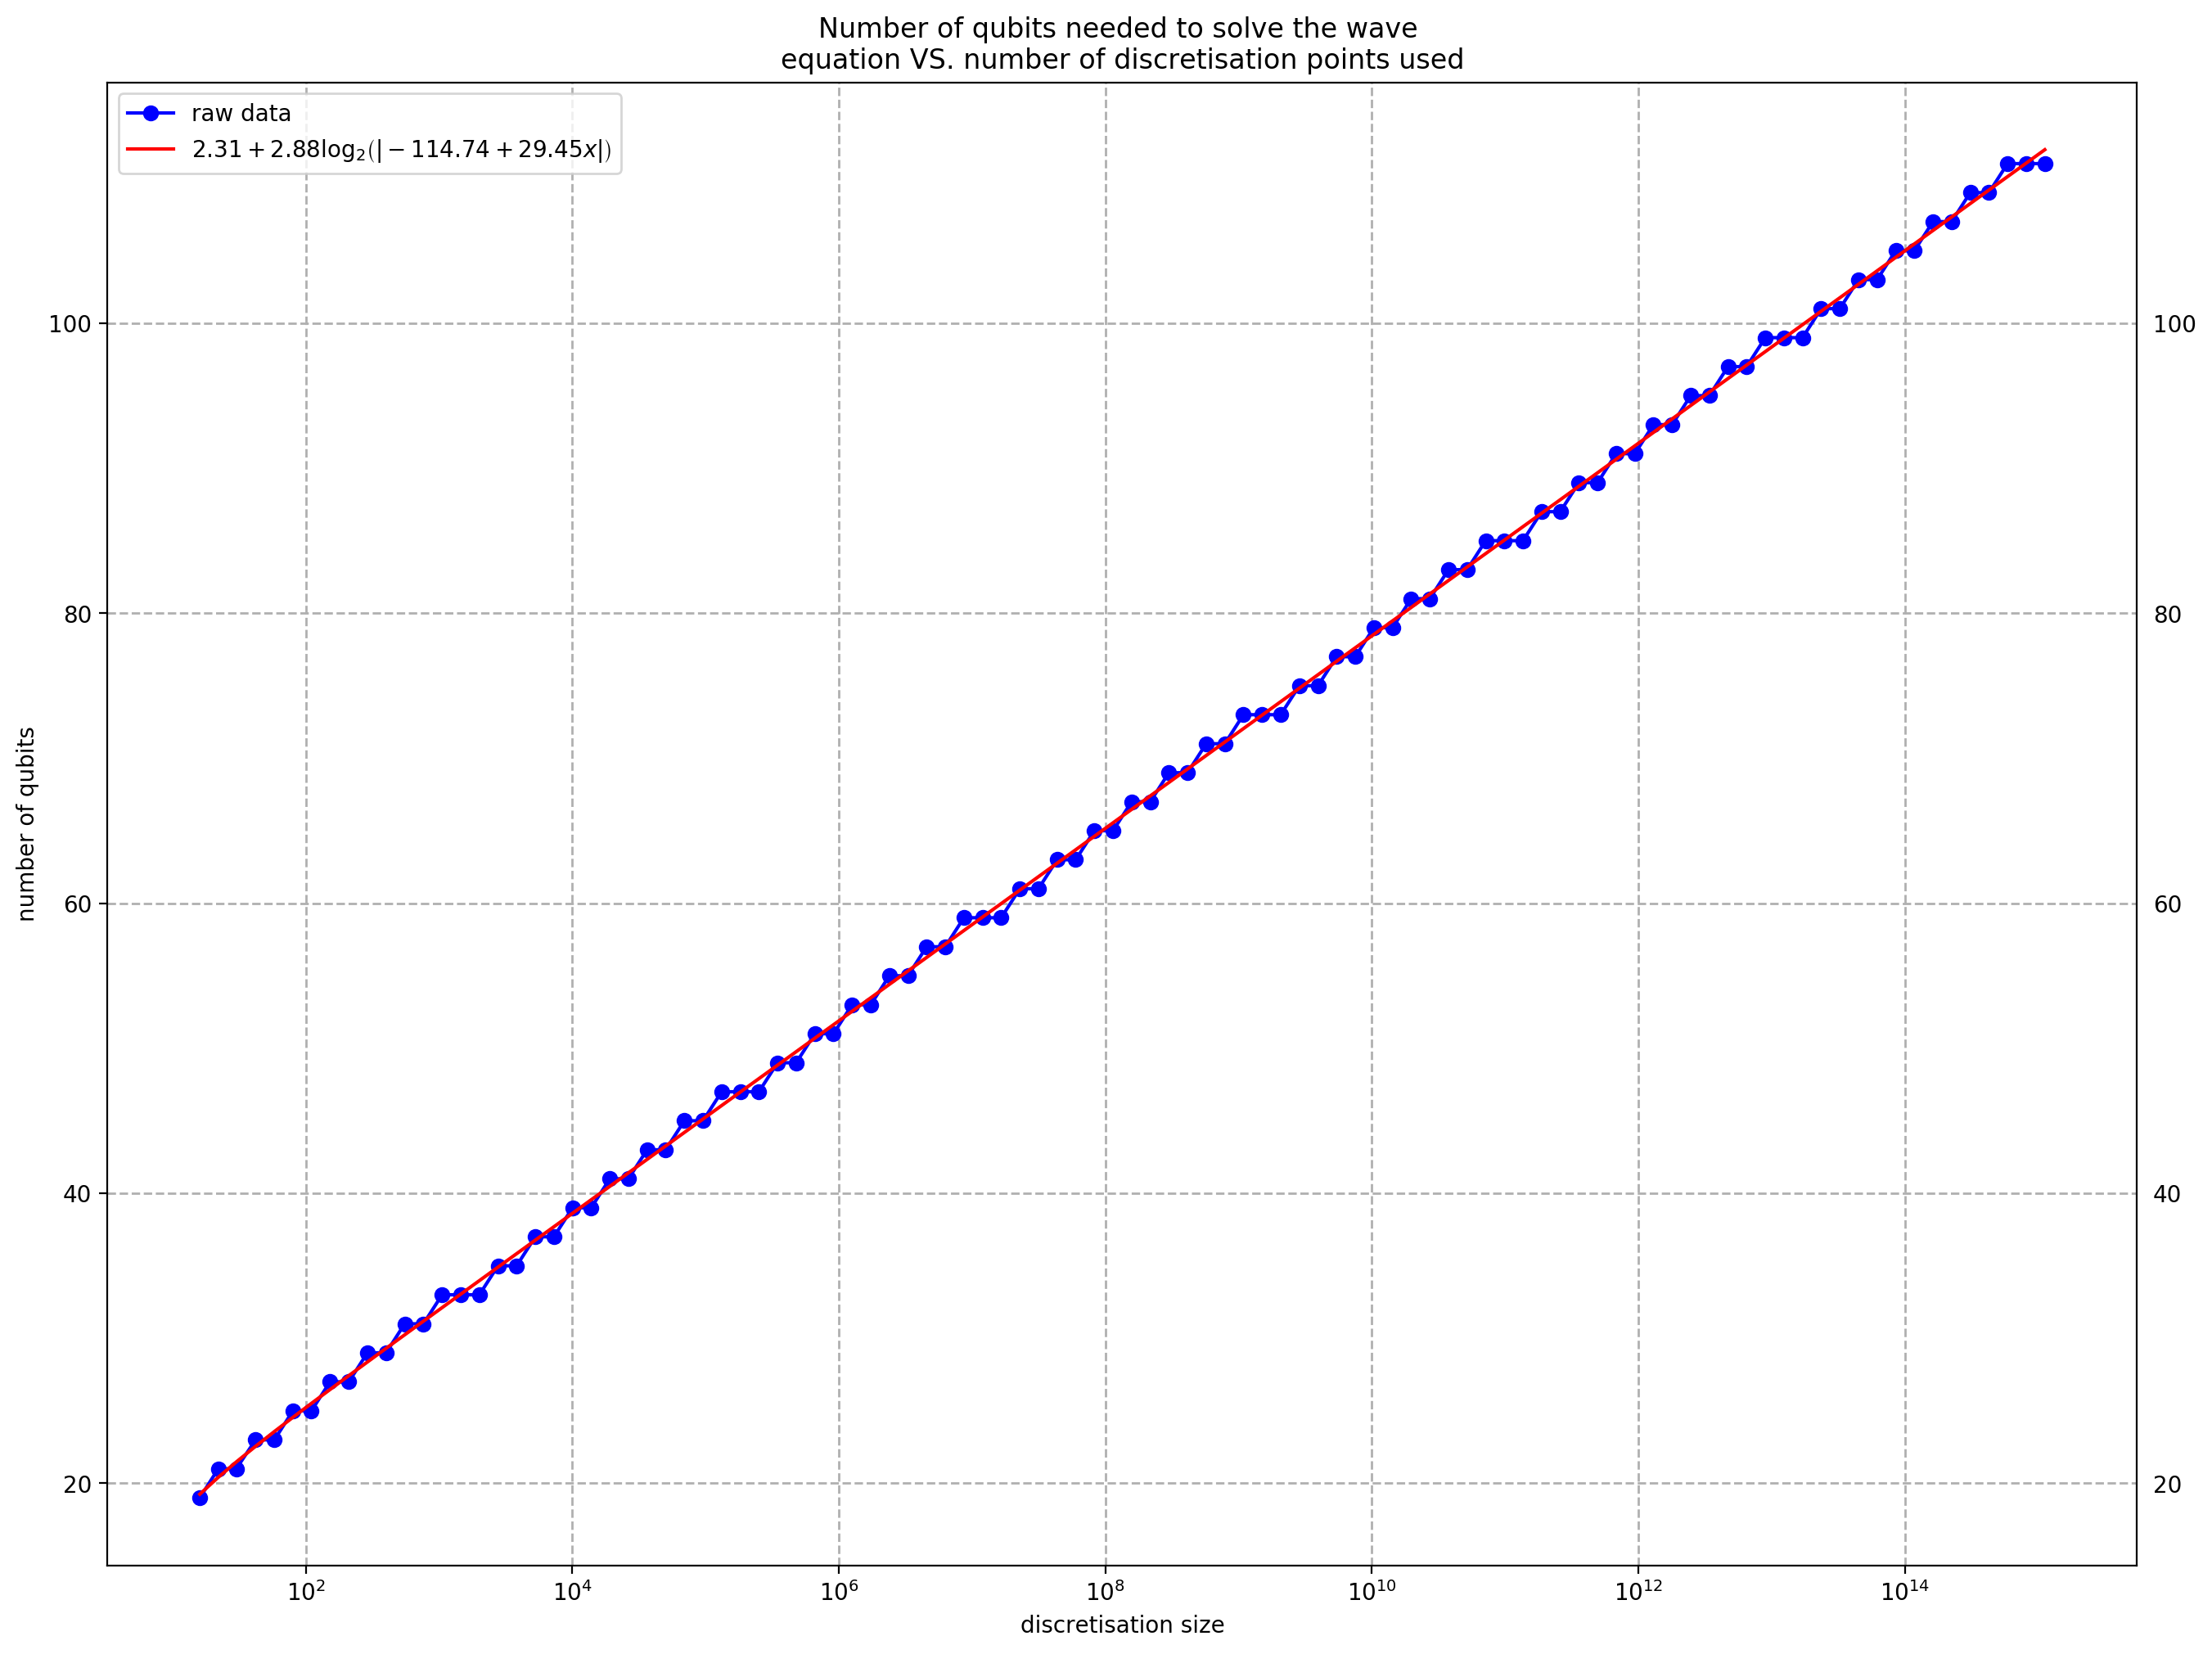

In [9]:
# Try to fit the data to (a + b*log(c + d*x))
popt = fit_to_polylog(discretisation_values, arities.values, 1)

fig, ax = plt.subplots(figsize = (16, 12), dpi=matplotlib_dpi)

ax.plot(discretisation_values, arities.values, '-ob', label="raw data")
ax.plot(discretisation_values, get_polylog_func(1)(discretisation_values, *popt), 'r-', 
        label=get_polylog_latex(1, *popt))
ax.set_xscale('log')
ax.set_xlabel("discretisation size")
ax.set_ylabel("number of qubits")
ax.set_title("Number of qubits needed to solve the wave \nequation VS. number of discretisation points used")
ax.grid(True, axis="both", linestyle="--", linewidth=1, which='both')
ax.legend(loc='upper left')
ax.tick_params(labeltop=False, labelright=True)
plt.show()

### 2. Performance of circuit generation and optimisation

Next, we would like to know if the circuit generation, the exportation to Atos' Circuit format and the optimisation of the circuit are cheap operations, and how they seems to scale.

Trying lm... Succeed!
Trying lm... Succeed!
Trying lm... Succeed!
Trying lm... Succeed!
Trying lm... Failed!
Trying trf... Failed!
Trying dogbox... Succeed!
Trying lm... Succeed!
Trying lm... Succeed!


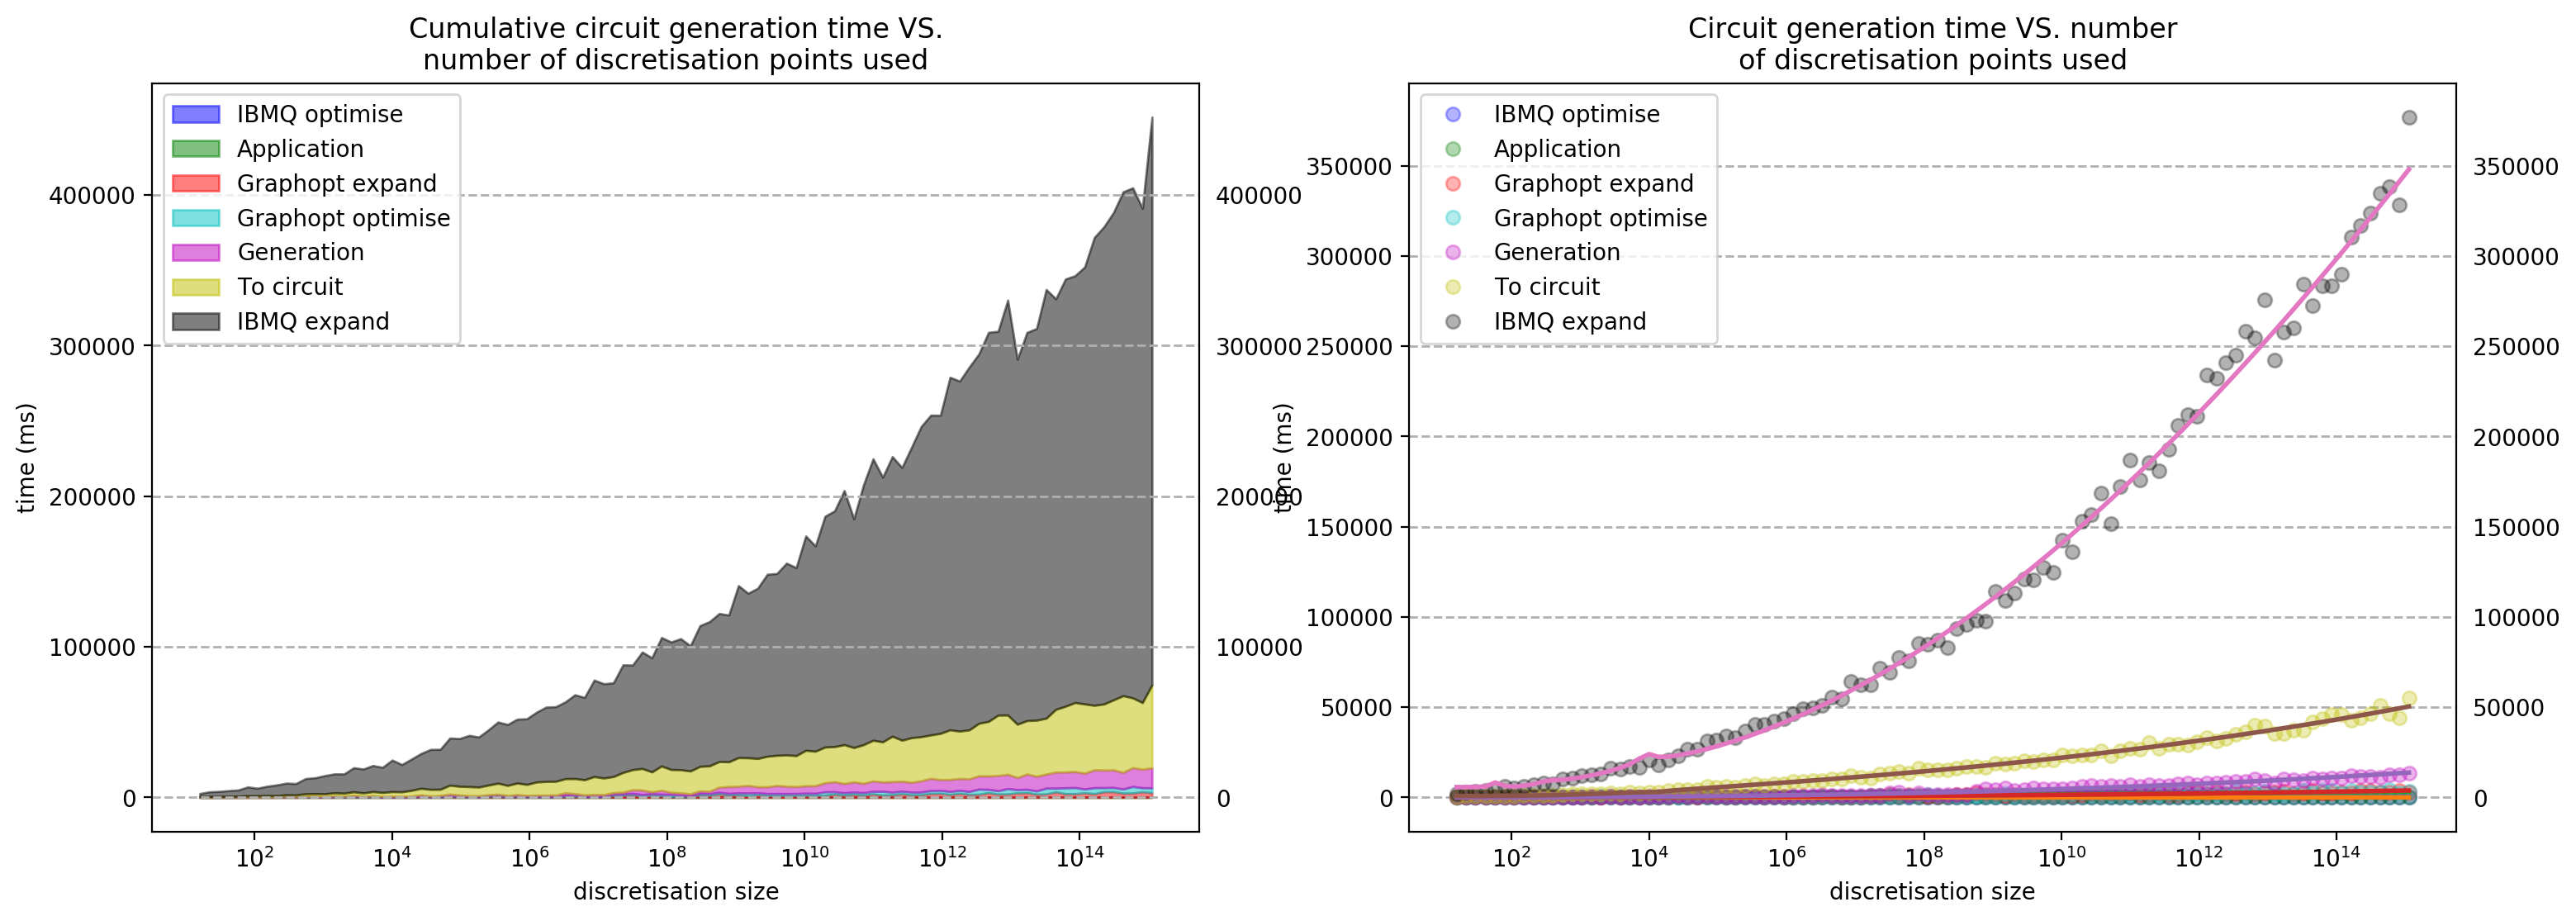

Function fitting the values of 'Application':


<IPython.core.display.Math object>

Function fitting the values of 'Graphopt optimise':


<IPython.core.display.Math object>

Function fitting the values of 'IBMQ optimise':


<IPython.core.display.Math object>

Function fitting the values of 'To circuit':


<IPython.core.display.Math object>

Function fitting the values of 'Generation':


<IPython.core.display.Math object>

Function fitting the values of 'Graphopt expand':


<IPython.core.display.Math object>

Function fitting the values of 'IBMQ expand':


<IPython.core.display.Math object>

In [10]:
fig, axes = plt.subplots(ncols=2,
                         subplot_kw = {
                             "xscale": "log",
                             "xlabel": "discretisation size",
                             "ylabel": "time (ms)",
                         },
                         figsize = (18,6), dpi = matplotlib_dpi)

labels = [label.replace("_time_ms", "").replace("_", " ") for label in time_statistics.index]

cumulative_plot(discretisation_values, 
                time_statistics.values,
                labels,
                ax = axes[0])

_, latex_expr = non_cumulative_plot(discretisation_values, 
                                    time_statistics.values,
                                    labels,
                                    ax = axes[1],
                                    fitting_power=3,
                                    fitting_margin=0.05)

axes[0].set_title("Cumulative circuit generation time VS.\nnumber of discretisation points used")
axes[1].set_title("Circuit generation time VS. number\nof discretisation points used")
axes[0].grid(True, axis="y", linestyle="--", linewidth=1)
axes[1].grid(True, axis="y", linestyle="--", linewidth=1)
axes[0].tick_params(labeltop=False, labelright=True)
axes[1].tick_params(labeltop=False, labelright=True)
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
plt.show()

for label, latex in latex_expr.items():
    print("Function fitting the values of '{}':".format(label))
    display(Math(latex))

### 3. Number of gates in the generated circuit

The number of gates is a crucial indicator of the performance of our solver. In the graphs below we only consider the number of gates **at generation**. Optimised circuits are taken into account in a following section.

Trying lm... Succeed!
Trying lm... Succeed!
Trying lm... Failed!
Trying trf... Succeed!
Trying lm... Failed!
Trying trf... Succeed!
Trying lm... Succeed!
Trying lm... Succeed!
Trying lm... Succeed!


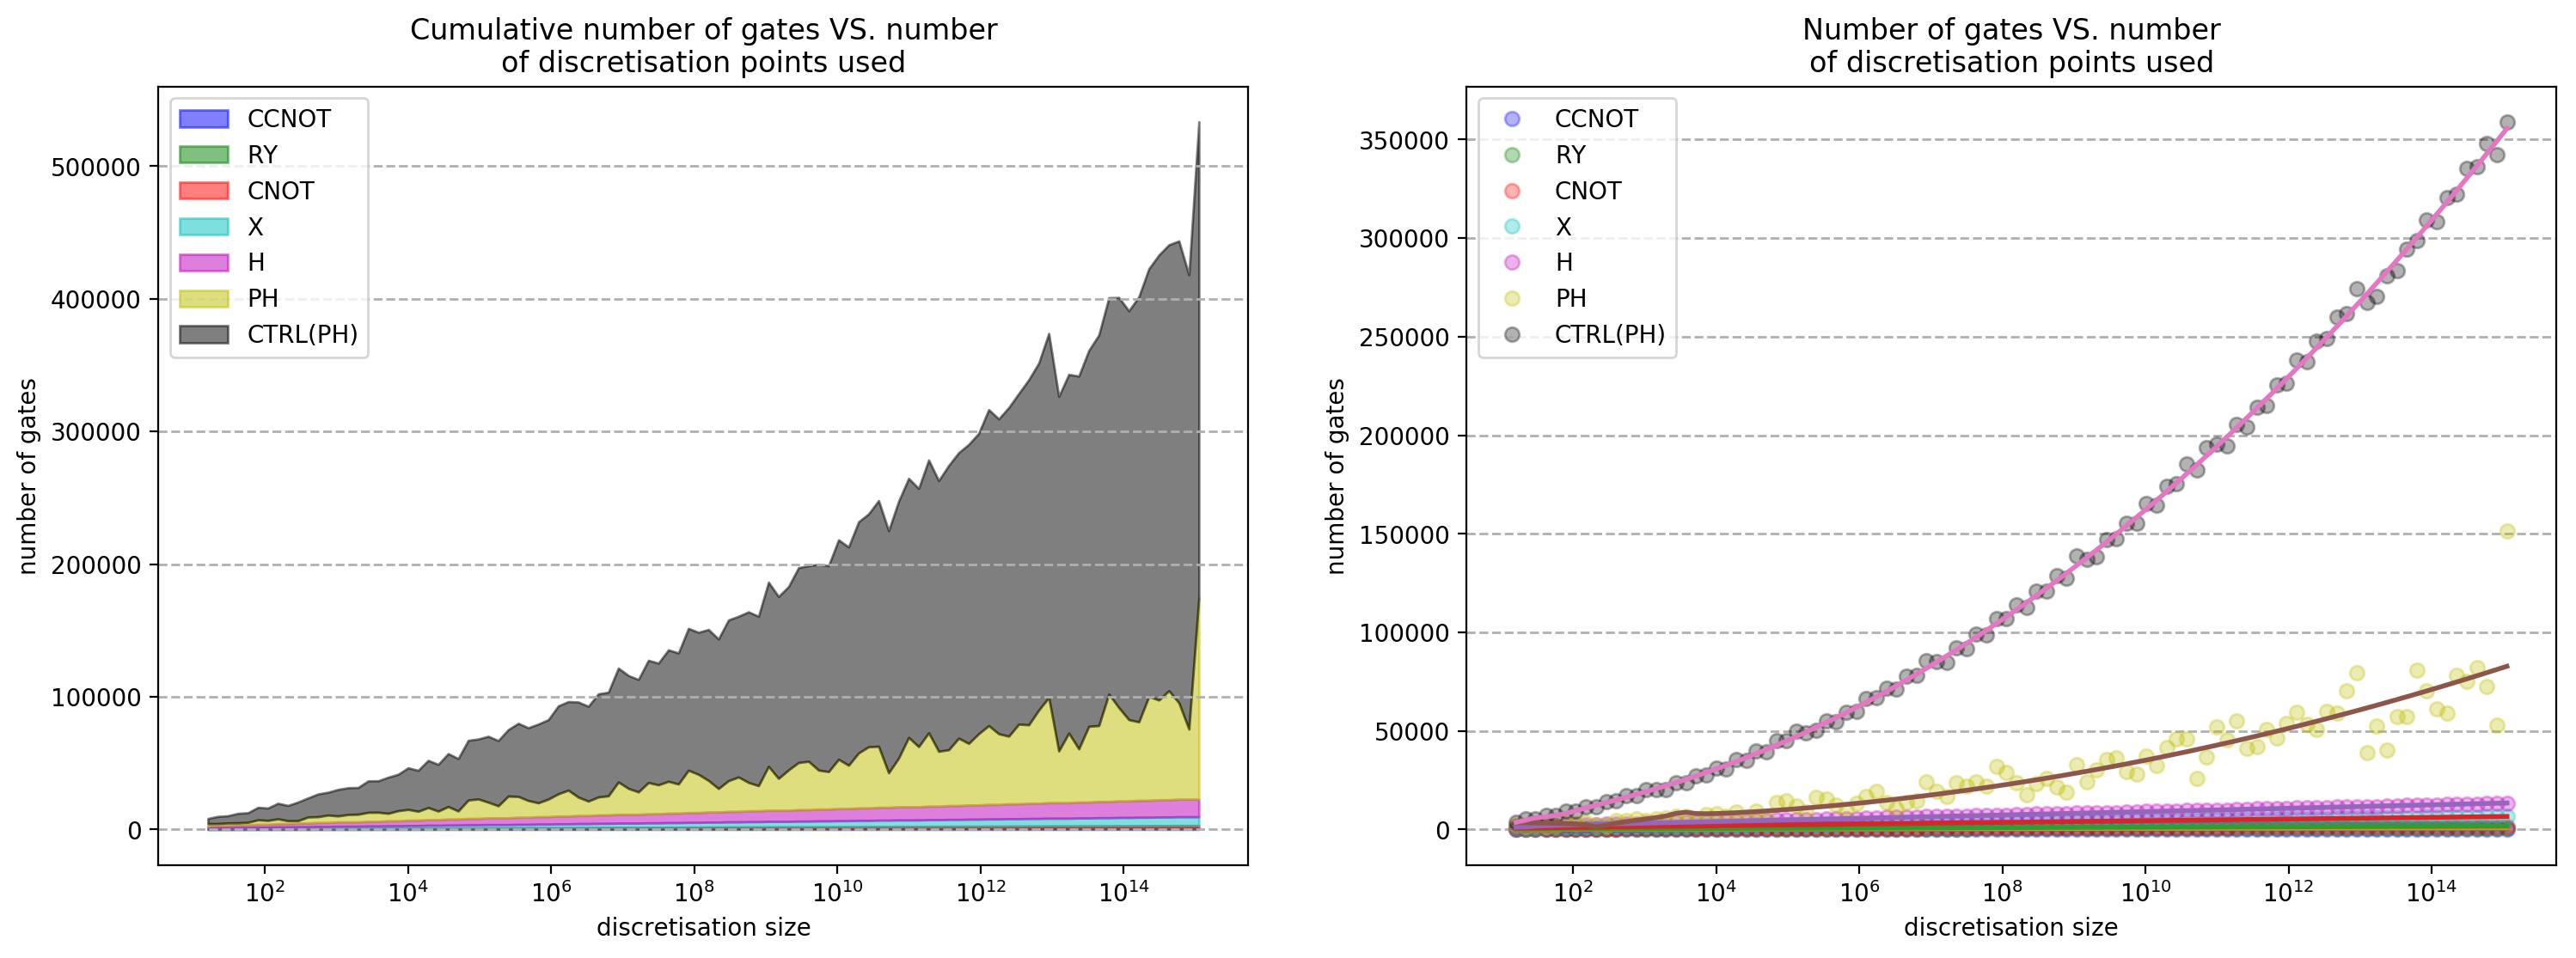

Function fitting the values of 'CNOT':


<IPython.core.display.Math object>

Function fitting the values of 'X':


<IPython.core.display.Math object>

Function fitting the values of 'RY':


<IPython.core.display.Math object>

Function fitting the values of 'PH':


<IPython.core.display.Math object>

Function fitting the values of 'H':


<IPython.core.display.Math object>

Function fitting the values of 'CTRL(PH)':


<IPython.core.display.Math object>

Function fitting the values of 'CCNOT':


<IPython.core.display.Math object>

In [11]:
generated_gates_stats = gate_statistics.loc["circ_gate_count"]
gate_names = list(generated_gates_stats.index)

# Then we can plot
fig, axes = plt.subplots(ncols=2,
                         subplot_kw = {
                             "xscale": "log",
                             "xlabel": "discretisation size",
                             "ylabel": "number of gates",
                         },
                         figsize = (18,6), dpi = matplotlib_dpi)

cumulative_plot(discretisation_values, 
                generated_gates_stats.values,
                gate_names,
                ax = axes[0])

_, latex_expr = non_cumulative_plot(discretisation_values, 
                                    generated_gates_stats.values,
                                    gate_names,
                                    ax = axes[1],
                                    fitting_power = 2)

axes[0].set_title("Cumulative number of gates VS. number\nof discretisation points used")
axes[1].set_title("Number of gates VS. number\nof discretisation points used")
for i in range(2):
    axes[i].grid(True, axis="y", linestyle="--", linewidth=1)
    axes[i].legend(loc='upper left')
plt.show()

for label, latex in latex_expr.items():
    if latex is None:
        print("No fitting found for the values of '{}'.".format(label))
    else:
        print("Function fitting the values of '{}':".format(label))
        display(Math(latex))

### 4. Number of gates in the circuit translated to IBMQ

The number of gates is a crucial indicator of the performance of our solver. As the final goal will be to run our solver on a real quantum computer, we need to analyse the number of gates that will be needed **on the hardware**. This number is quite different from the number of generated gates as most of the time the hardware implements only a subset of the gates available at generation.

Trying lm... Failed!
Trying trf... Succeed!
Trying lm... Succeed!
Trying lm... Succeed!
Trying lm... Succeed!
Plots are over!
Matplotlib show!!


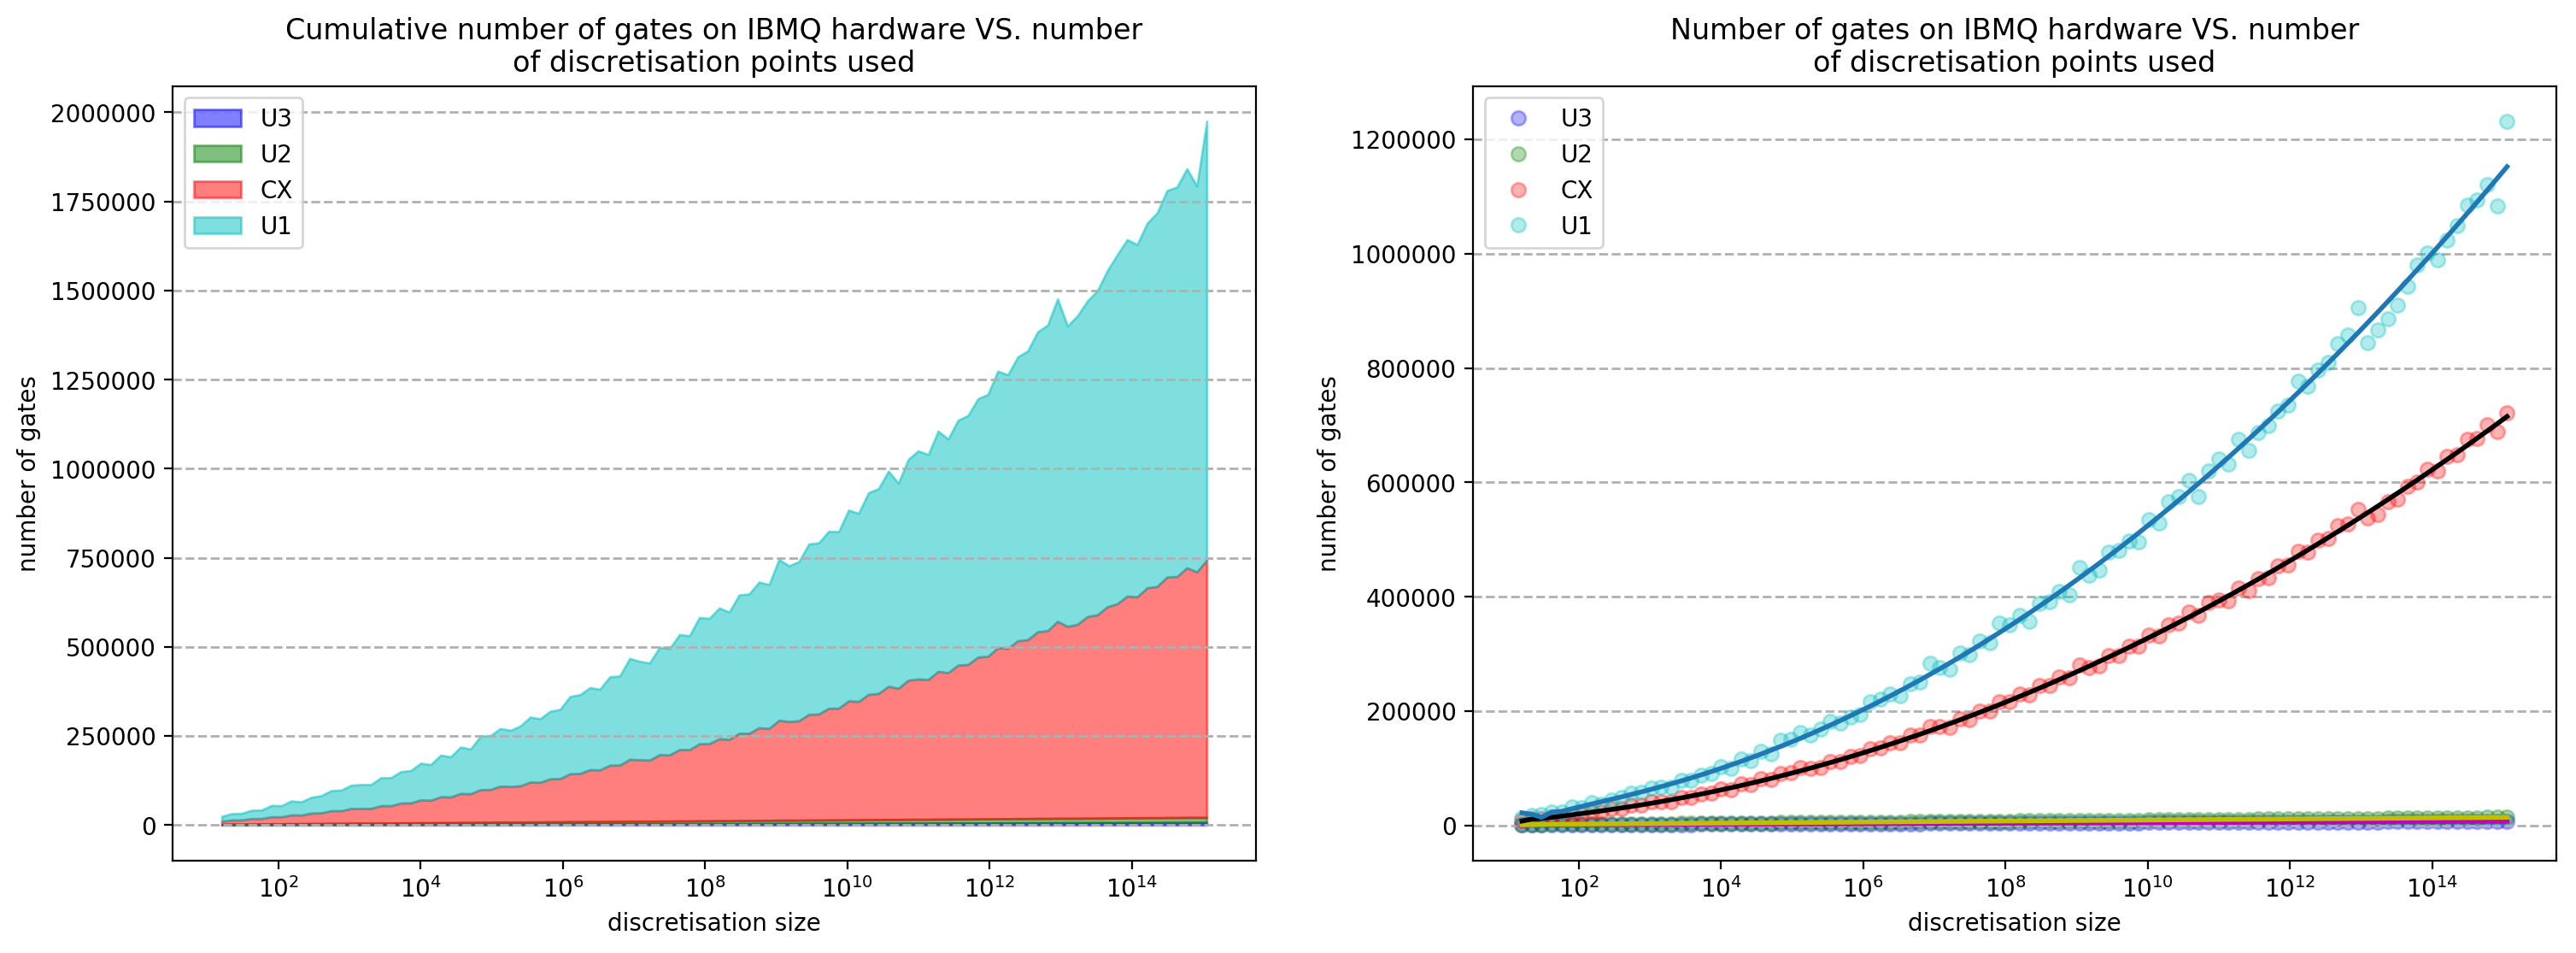

End of the show!
Function fitting the values of 'U1':


<IPython.core.display.Math object>

Function fitting the values of 'U2':


<IPython.core.display.Math object>

Function fitting the values of 'CX':


<IPython.core.display.Math object>

Function fitting the values of 'U3':


<IPython.core.display.Math object>

In [12]:
ibmq_gates_stats = gate_statistics.loc["ibmq_circ_gate_count"]
ibmq_gate_names = list(ibmq_gates_stats.index)

# Then we can plot
fig, axes = plt.subplots(ncols=2,
                         subplot_kw = {
                             "xscale": "log",
                             "xlabel": "discretisation size",
                             "ylabel": "number of gates",
                         },
                         figsize = (18,6), dpi = matplotlib_dpi)

cumulative_plot(discretisation_values, 
                ibmq_gates_stats.values,
                ibmq_gate_names,
                ax = axes[0])

_, latex_expr = non_cumulative_plot(discretisation_values, 
                                    ibmq_gates_stats.values,
                                    ibmq_gate_names,
                                    ax = axes[1],
                                    fitting_power = 2)

print("Plots are over!", flush=True)
axes[0].set_title("Cumulative number of gates on IBMQ hardware VS. number\nof discretisation points used")
axes[1].set_title("Number of gates on IBMQ hardware VS. number\nof discretisation points used")
for i in range(2):
    axes[i].grid(True, axis="y", linestyle="--", linewidth=1)
    axes[i].legend(loc='upper left')
print("Matplotlib show!!", flush=True)
plt.show()
print("End of the show!", flush=True)

for label, latex in latex_expr.items():
    if latex is None:
        print("No fitting found for the values of '{}'.".format(label))
    else:
        print("Function fitting the values of '{}':".format(label))
        display(Math(latex))

### 5. Time needed to execute the solver on the Melbourne chip

Trying lm... Succeed!


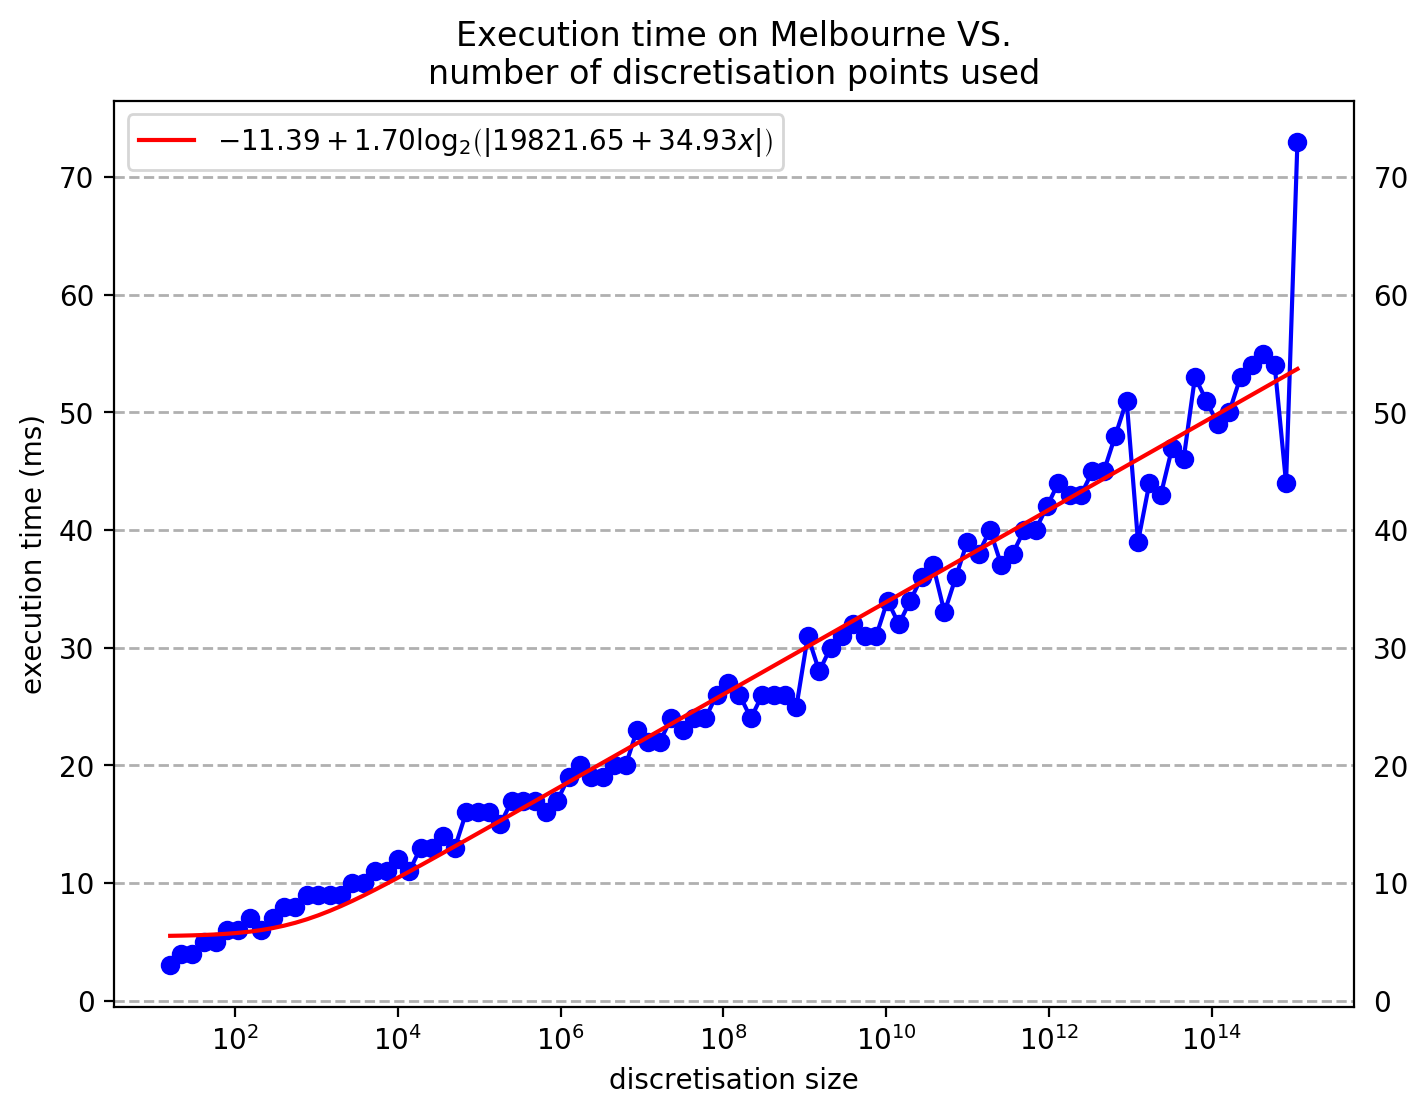

In [13]:
melbourne_exec_ms = melbourne_exec_time.values // 10**6

# Try to fit the data to (a + b*log(c + d*x))
popt = fit_to_polylog(discretisation_values, melbourne_exec_ms, 1)

fig, ax = plt.subplots(figsize = (8, 6), dpi = matplotlib_dpi)

ax.plot(discretisation_values, melbourne_exec_ms, '-ob', label="")
ax.plot(discretisation_values, get_polylog_func(1)(discretisation_values, *popt), 'r-', 
        label=get_polylog_latex(1, *popt))
ax.set_xscale('log')
ax.set_xlabel("discretisation size")
ax.set_ylabel("execution time (ms)")
ax.set_title("Execution time on Melbourne VS.\nnumber of discretisation points used")
ax.grid(True, axis="y", linestyle="--", linewidth=1, which='both')
ax.legend(loc='upper left')
ax.tick_params(labeltop=False, labelright=True)
plt.show()